<a href="https://www.kaggle.com/code/roundv/understanding-of-jpx-prediction-dataset?scriptVersionId=93597732" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Init

In [1]:
import os
from pathlib import Path
from decimal import ROUND_HALF_UP, Decimal

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

In [2]:
# Draw finance chart
!pip install mplfinance
import mplfinance as mpf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.4/70.4 KB 829.2 kB/s eta 0:00:00


In [3]:
# I/O Func
def adjusting_price(price, key: str):
    """[Adjusting Close Price]
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
    Returns:
        price DataFrame (pd.DataFrame): stock_price with generated AdjustedClose
    """

    def generate_adjusted(df):
        """
        Args:
            df (pd.DataFrame)  : stock_price for a single SecuritiesCode
        Returns:
            df (pd.DataFrame): stock_price with AdjustedClose for a single SecuritiesCode
        """
        # sort data to generate CumulativeAdjustmentFactor
        df = df.sort_values("Date", ascending=False)
        # generate CumulativeAdjustmentFactor
        df.loc[:, f"CumulativeAdjustmentFactor{key}"] = df["AdjustmentFactor"].cumprod()
        # generate AdjustedClose
        df.loc[:, f"Adjusted{key}"] = (
            df[f"CumulativeAdjustmentFactor{key}"] * df[key]
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        ))
        # reverse order
        df = df.sort_values("Date")
        # to fill AdjustedClose, replace 0 into np.nan
        df.loc[df[f"Adjusted{key}"] == 0, f"Adjusted{key}"] = np.nan
        # forward fill AdjustedClose
        df.loc[:, f"Adjusted{key}"] = df.loc[:, f"Adjusted{key}"].ffill()
        return df

    # generate AdjustedClose
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_adjusted).reset_index(drop=True)

    # price.set_index("Date", inplace=True)
    return price

def adjusting_volume(price, key = "Volume"):
    """[Adjusting Close Price]
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
    Returns:
        price DataFrame (pd.DataFrame): stock_price with generated AdjustedClose
    """

    def generate_adjusted(df):
        """
        Args:
            df (pd.DataFrame)  : stock_price for a single SecuritiesCode
        Returns:
            df (pd.DataFrame): stock_price with AdjustedClose for a single SecuritiesCode
        """
        # sort data to generate CumulativeAdjustmentFactor
        df = df.sort_values("Date", ascending=False)
        # generate CumulativeAdjustmentFactor
        df.loc[:, f"CumulativeAdjustmentFactor{key}"] = df["AdjustmentFactor"].cumprod()
        # generate AdjustedClose
        df.loc[:, f"Adjusted{key}"] = (
            df[key] / df[f"CumulativeAdjustmentFactor{key}"]  
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        ))
        # reverse order
        df = df.sort_values("Date")
        # to fill AdjustedClose, replace 0 into np.nan
        df.loc[df[f"Adjusted{key}"] == 0, f"Adjusted{key}"] = np.nan
        # forward fill AdjustedClose
        df.loc[:, f"Adjusted{key}"] = df.loc[:, f"Adjusted{key}"].ffill()
        return df

    # generate AdjustedClose
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_adjusted).reset_index(drop=True)

    # price.set_index("Date", inplace=True)
    return price

def read_prices(dir_name: str, securities_code: int = None):
    """[Important: the dateset of 2020/10/1 is lost because of system failer in JPX, see: https://www.jpx.co.jp/corporate/news/news-releases/0060/20201019-01.html]
    
    """
    base_path = Path(f'../input/jpx-tokyo-stock-exchange-prediction/{dir_name}')
    df = pd.read_csv(base_path / 'stock_prices.csv')
    df.loc[: ,"Date"] = pd.to_datetime(df.loc[: ,"Date"], format="%Y-%m-%d")
    df = df[df['Open'].notna()]
    if securities_code:
        df = df[df["SecuritiesCode"] == securities_code]
    return df

def read_stock_list(securities_code: int = None, only_universe: bool = True):
    df = pd.read_csv('../input/jpx-tokyo-stock-exchange-prediction/stock_list.csv')
    df.loc[: ,"EffectiveDate"] = pd.to_datetime(df.loc[: ,"EffectiveDate"], format="%Y%m%d")
    if only_universe:
        df = df[df['Universe0']]
    if securities_code:
        df = df[df["SecuritiesCode"] == securities_code]
    return df

def read_train_data_by_price(securities_code: int = None, with_supplemental: bool = True):
    """[The train base is price dataset, the other data are joined to prices DF by left join]
    
    """
    def merge_data(prices, stock_list):
        base_df = prices.copy()
        _stock_list = stock_list.copy()
        _stock_list.rename(columns={'Close': 'Close_x'}, inplace=True)
        base_df = base_df.merge(_stock_list, on='SecuritiesCode', how="left")
        return base_df
    
    # origin
    df = merge_data(prices=read_prices(dir_name="train_files", securities_code=securities_code), stock_list=read_stock_list(securities_code=securities_code))
    
    # supplyment
    if with_supplemental:
        supplemental_df = merge_data(prices=read_prices(dir_name="supplemental_files", securities_code=securities_code), stock_list=read_stock_list(securities_code=securities_code))
        df = pd.concat([df, supplemental_df]).reset_index(drop=True)
        
    df = adjusting_price(df, "Close")
    df = adjusting_price(df, "Open")
    df = adjusting_price(df, "High")
    df = adjusting_price(df, "Low")
    df = adjusting_volume(df)
    return df

def write_df(df, filename):
    base_path = Path(f'/kaggle/working')
    df.to_csv(base_path / f'{filename}.csv',index = False)

In [4]:
# Draw Func
import seaborn as sns
def draw_pie(df, target):
    val_cnt = df[target].value_counts()
    pct = val_cnt / val_cnt.sum() * 100
    labels = [f"{sec} {ratio:.2f}%" for sec, ratio in zip(val_cnt.index, pct)]

    fig, ax = plt.subplots(figsize=(10, 5))
    patches, texts = ax.pie(val_cnt.values, 
                            colors=sns.color_palette("pastel"), 
                            shadow=True, 
                            startangle=90)
    patches, labels, dummy = zip(*sorted(zip(patches, labels, val_cnt.values),
                                         key=lambda x: x[2],
                                         reverse=True))
    ax.legend(patches, labels, bbox_to_anchor=(-0.1, 1.), fontsize=8)
    ax.set_title(f"Ratio of {target}")
    plt.show()
    
def draw_candlestick_chart(df, securities_code: int, datetime_index_name: str = "Date", open_name: str = "Open", high_name: str = "High", low_name: str = "Low", close_name: str = "Close", volume_name: str = "Volume"):
    """
    Index is DatetimeIndex and Open, High, Low, Close, Volume
    """
    tmp_df = df.copy()
    tmp_df = tmp_df[tmp_df["SecuritiesCode"] == securities_code]
    tmp_df = tmp_df[tmp_df["SecuritiesCode"] == securities_code]
    tmp_df = tmp_df[[datetime_index_name, open_name, high_name, low_name, close_name, volume_name]]
    tmp_df.rename(columns={open_name: 'Open'}, inplace=True)
    tmp_df.rename(columns={high_name: 'High'}, inplace=True)
    tmp_df.rename(columns={low_name: 'Low'}, inplace=True)
    tmp_df.rename(columns={close_name: 'Close'}, inplace=True)
    tmp_df.rename(columns={volume_name: 'Volume'}, inplace=True)
    tmp_df = tmp_df.set_index(datetime_index_name)
    
    # daily

    mpf.plot(tmp_df, type='candle', figratio=(12,4), volume=True, mav=(5, 25), style='yahoo')
    
    # weekly
    d_ohlcv = {'Open': 'first',
           'High': 'max',
           'Low': 'min',
           'Close': 'last',
           'Volume': 'sum'}
    df_w = tmp_df.resample('W-MON', closed='left', label='left').agg(d_ohlcv)
    mpf.plot(df_w, type='candle', figratio=(12,4), volume=True, mav=(5, 25), style='yahoo')

In [5]:
TOYOTA = 7203

# Stock List

In [6]:
# stock list
stock_list = read_stock_list()
stock_list

,SecuritiesCode,EffectiveDate,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,TradeDate,Close,IssuedShares,MarketCapitalization,Universe0
0,1301,2021-12-30,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,20211230.0,3080.0,10928283.0,3.365911e+10,True
19,1332,2021-12-30,"Nippon Suisan Kaisha,Ltd.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,4,TOPIX Mid400,20211230.0,543.0,312430277.0,1.696496e+11,True
20,1333,2021-12-30,Maruha Nichiro Corporation,First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,4,TOPIX Mid400,20211230.0,2405.0,52656910.0,1.266399e+11,True
37,1375,2021-12-30,"YUKIGUNI MAITAKE CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,6,TOPIX Small 1,20211230.0,1196.0,39910700.0,4.773320e+10,True
38,1376,2021-12-30,"KANEKO SEEDS CO.,LTD.",First Section (Domestic),Standard Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,20211230.0,1504.0,11772626.0,1.770603e+10,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4408,9990,2021-12-30,SAC'S BAR HOLDINGS INC.,First Section (Domestic),Prime Market,6100,Retail Trade,14,RETAIL TRADE,7,TOPIX Small 2,20211230.0,518.0,29859900.0,1.546743e+10,True
4409,9991,2021-12-30,GECOSS CORPORATION,First Section (Domestic),Prime Market,6050,Wholesale Trade,13,COMMERCIAL & WHOLESALE TRADE,7,TOPIX Small 2,20211230.0,825.0,36436125.0,3.005980e+10,True
4411,9993,2021-12-30,"YAMAZAWA CO.,LTD.",First Section (Domestic),Standard Market,6100,Retail Trade,14,RETAIL TRADE,7,TOPIX Small 2,20211230.0,1626.0,10960825.0,1.782230e+10,True
4412,9994,2021-12-30,YAMAYA CORPORATION,First Section (Domestic),Standard Market,6100,Retail Trade,14,RETAIL TRADE,7,TOPIX Small 2,20211230.0,2447.0,10847870.0,2.654474e+10,True


In [7]:
stock_list.nunique()

SecuritiesCode            2000
EffectiveDate                1
Name                      1998
Section/Products             5
NewMarketSegment             3
33SectorCode                33
33SectorName                33
17SectorCode                17
17SectorName                17
NewIndexSeriesSizeCode       6
NewIndexSeriesSize           6
TradeDate                    3
Close                     1538
IssuedShares              1984
MarketCapitalization      2000
Universe0                    1
dtype: int64

In [8]:
print(stock_list.dtypes)

SecuritiesCode                     int64
EffectiveDate             datetime64[ns]
Name                              object
Section/Products                  object
NewMarketSegment                  object
33SectorCode                      object
33SectorName                      object
17SectorCode                      object
17SectorName                      object
NewIndexSeriesSizeCode            object
NewIndexSeriesSize                object
TradeDate                        float64
Close                            float64
IssuedShares                     float64
MarketCapitalization             float64
Universe0                           bool
dtype: object


In [9]:
stock_list["EffectiveDate"].describe()

count                    2000
unique                      1
top       2021-12-30 00:00:00
freq                     2000
first     2021-12-30 00:00:00
last      2021-12-30 00:00:00
Name: EffectiveDate, dtype: object

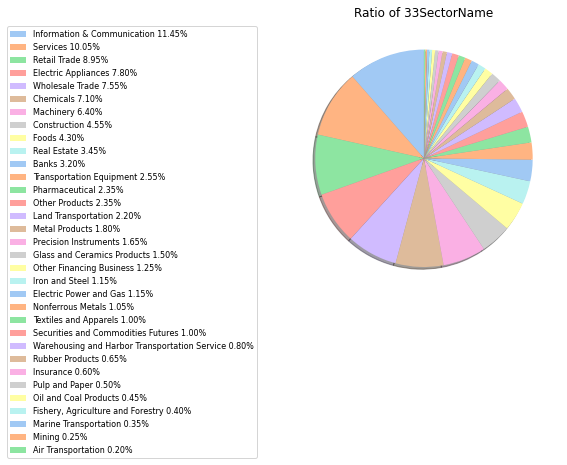

In [10]:
draw_pie(stock_list, '33SectorName')

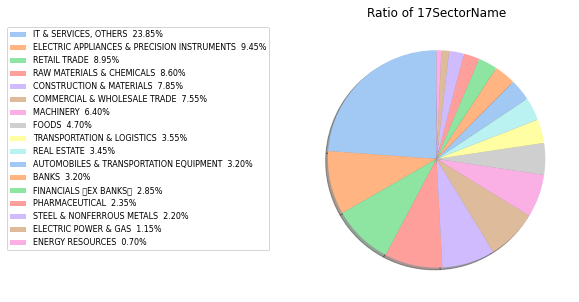

In [11]:
draw_pie(stock_list, '17SectorName')

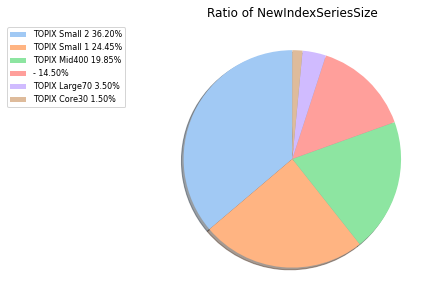

In [12]:
draw_pie(stock_list, 'NewIndexSeriesSize')

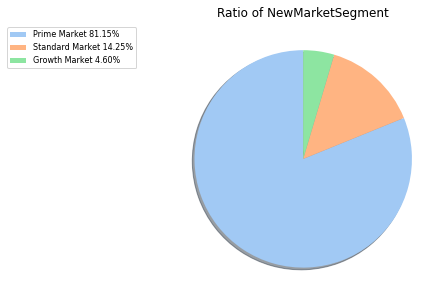

In [13]:
draw_pie(stock_list, 'NewMarketSegment')

# Prices

In [14]:
train_prices = read_train_data_by_price()
train_prices

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,...,CumulativeAdjustmentFactorClose,AdjustedClose,CumulativeAdjustmentFactorOpen,AdjustedOpen,CumulativeAdjustmentFactorHigh,AdjustedHigh,CumulativeAdjustmentFactorLow,AdjustedLow,CumulativeAdjustmentFactorVolume,AdjustedVolume
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,...,1.0,2742.0,1.0,2734.0,1.0,2755.0,1.0,2730.0,1.0,31400.0
1,20170105_1301,2017-01-05,1301,2743.0,2747.0,2735.0,2738.0,17900,1.0,NaN,...,1.0,2738.0,1.0,2743.0,1.0,2747.0,1.0,2735.0,1.0,17900.0
2,20170106_1301,2017-01-06,1301,2734.0,2744.0,2720.0,2740.0,19900,1.0,NaN,...,1.0,2740.0,1.0,2734.0,1.0,2744.0,1.0,2720.0,1.0,19900.0
3,20170110_1301,2017-01-10,1301,2745.0,2754.0,2735.0,2748.0,24200,1.0,NaN,...,1.0,2748.0,1.0,2745.0,1.0,2754.0,1.0,2735.0,1.0,24200.0
4,20170111_1301,2017-01-11,1301,2748.0,2752.0,2737.0,2745.0,9300,1.0,NaN,...,1.0,2745.0,1.0,2748.0,1.0,2752.0,1.0,2737.0,1.0,9300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2436634,20220221_9997,2022-02-21,9997,725.0,729.0,719.0,727.0,116400,1.0,NaN,...,1.0,727.0,1.0,725.0,1.0,729.0,1.0,719.0,1.0,116400.0
2436635,20220222_9997,2022-02-22,9997,719.0,723.0,711.0,721.0,225500,1.0,NaN,...,1.0,721.0,1.0,719.0,1.0,723.0,1.0,711.0,1.0,225500.0
2436636,20220224_9997,2022-02-24,9997,709.0,725.0,708.0,719.0,195600,1.0,NaN,...,1.0,719.0,1.0,709.0,1.0,725.0,1.0,708.0,1.0,195600.0
2436637,20220225_9997,2022-02-25,9997,725.0,738.0,724.0,733.0,170500,1.0,NaN,...,1.0,733.0,1.0,725.0,1.0,738.0,1.0,724.0,1.0,170500.0


In [15]:
print(train_prices.dtypes)

RowId                                       object
Date                                datetime64[ns]
SecuritiesCode                               int64
Open                                       float64
High                                       float64
Low                                        float64
Close                                      float64
Volume                                       int64
AdjustmentFactor                           float64
ExpectedDividend                           float64
SupervisionFlag                               bool
Target                                     float64
EffectiveDate                       datetime64[ns]
Name                                        object
Section/Products                            object
NewMarketSegment                            object
33SectorCode                                object
33SectorName                                object
17SectorCode                                object
17SectorName                   

In [16]:
train_prices.nunique()

RowId                               2436639
Date                                   1257
SecuritiesCode                         2000
Open                                  23311
High                                  24190
Low                                   24135
Close                                 24292
Volume                                90761
AdjustmentFactor                         19
ExpectedDividend                        460
SupervisionFlag                           2
Target                               361803
EffectiveDate                             1
Name                                   1998
Section/Products                          5
NewMarketSegment                          3
33SectorCode                             33
33SectorName                             33
17SectorCode                             17
17SectorName                             17
NewIndexSeriesSizeCode                    6
NewIndexSeriesSize                        6
TradeDate                       

In [17]:
train_prices["Date"].describe()

count                 2436639
unique                   1257
top       2021-05-06 00:00:00
freq                     2000
first     2017-01-04 00:00:00
last      2022-02-28 00:00:00
Name: Date, dtype: object

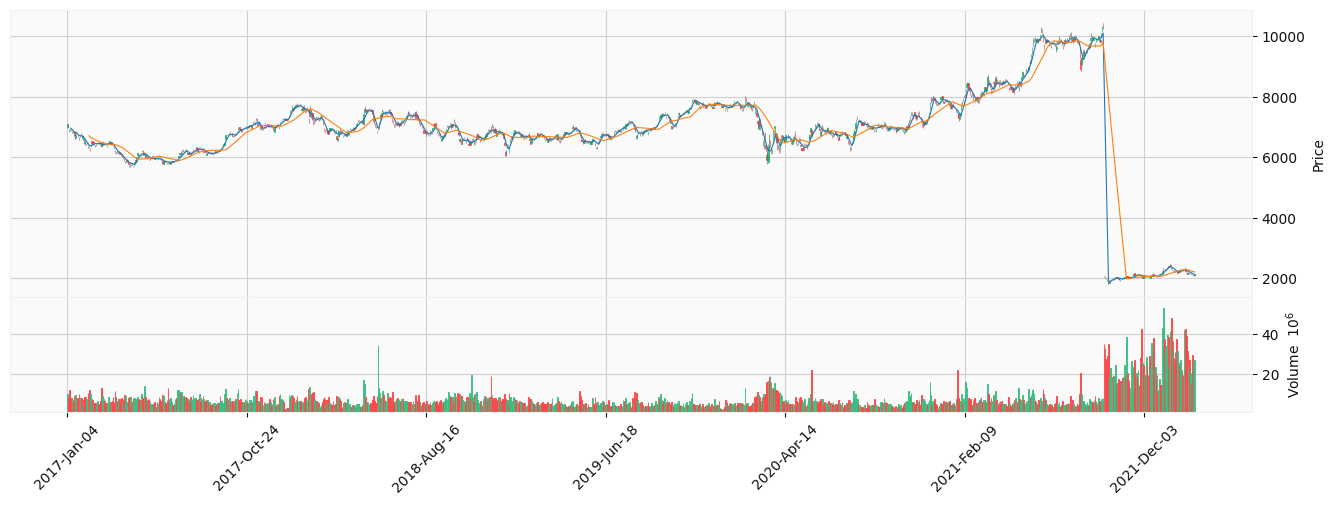

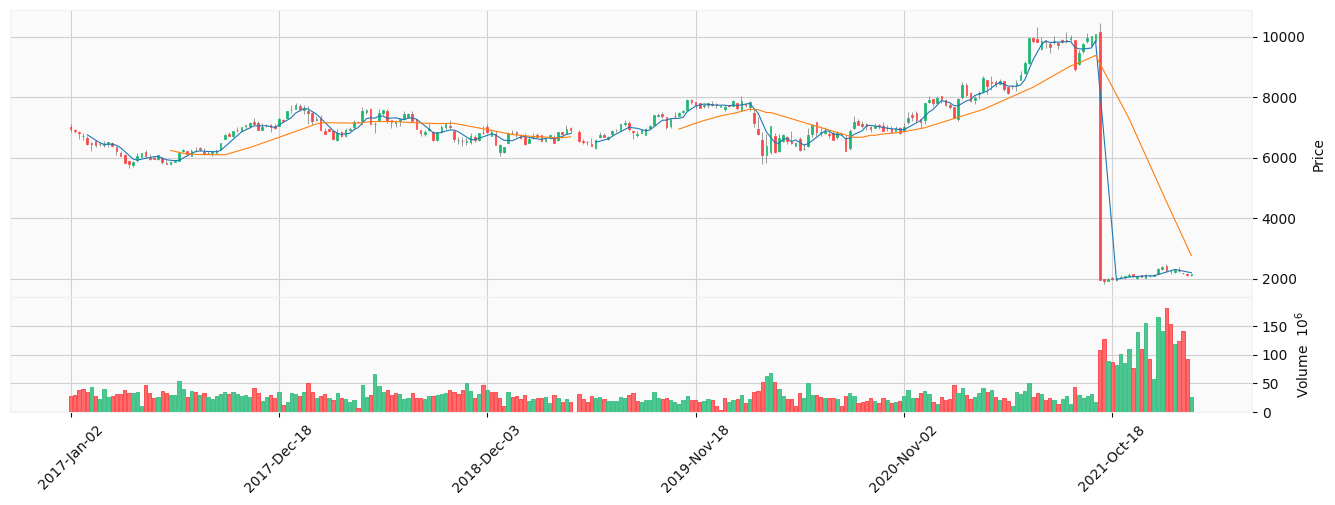

In [18]:
draw_candlestick_chart(df = train_prices, securities_code=TOYOTA)

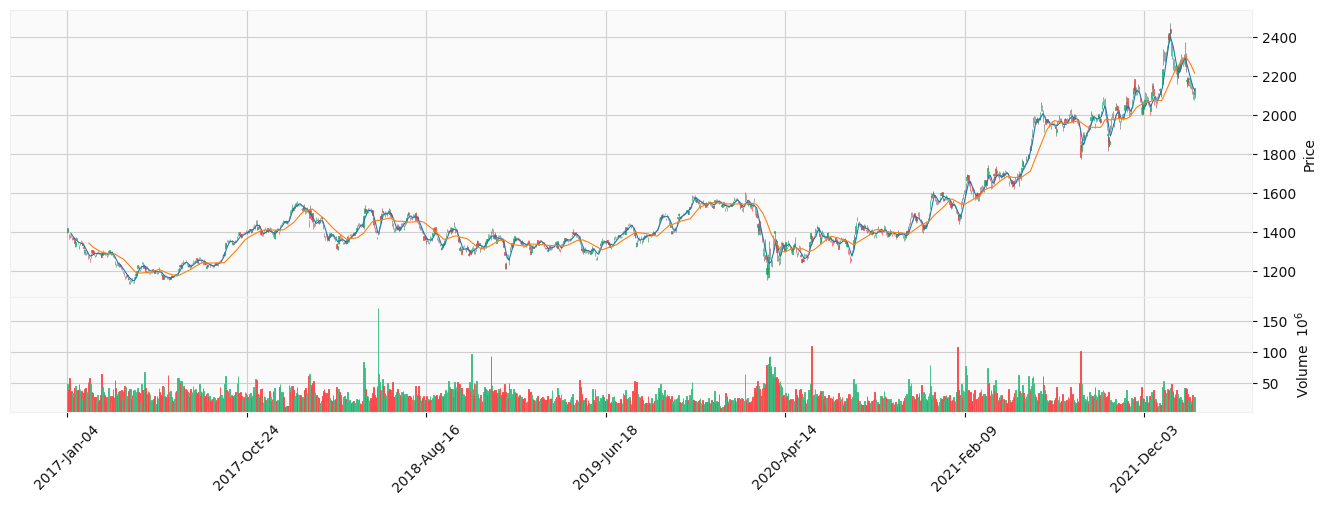

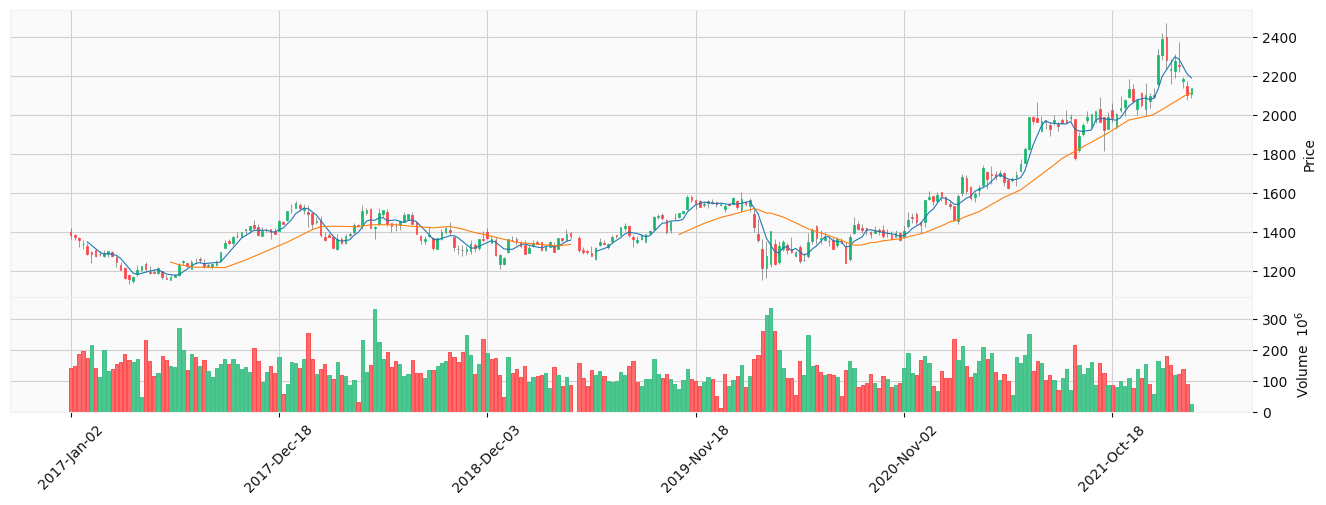

In [19]:
draw_candlestick_chart(df = train_prices, securities_code=TOYOTA, open_name = "AdjustedOpen", high_name = "AdjustedHigh", low_name  = "AdjustedLow", close_name = "AdjustedClose", volume_name = "AdjustedVolume")